In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.5)

In [406]:
# we add the parameter `low_memory=False` since pandas reads data from files in chunks by default.
# pandas also tries its best to decide on the `dtype` of the data in the chunk.
# what happened here was that another chunk turned out to be a different dtype.
# now we have 2 options, either we manually let pandas know the `dtype` or we let pandas pull the entire dataset in memory and decide
# since there is enough ram on this machine to pull the entire data, we took the option of using `low_memory=False`
inp0 = pd.read_csv('loan.csv', low_memory=False)
inp0.shape

(39717, 111)

* there are about 39k rows and 111 columns
* 111 columns are going to be too hard to work with for EDA so we need to find our columns which will be the drop candidates

### Data Cleaning - part 1
* identify empty columns and drop them
* identify empty rows and drop them
* de-duplicate the entire data
* identify columns with a single categorical value and drop them
* identify other irrelevant columns, like long text, non-url-part-urls

#### identify empty columns and drop them

In [407]:
temp = inp0.isnull() # this gives a dataframe with all cells as true/false. true if its empty/nan/null
temp = temp.sum() # sum() has a default parameter of axis=0 which will sum over a column. remember `True` == 1
temp = temp[temp > 35000] # we choose all columns which have about 35k out of 39k missing values in their rows
print(temp.size) # 56 of them have more than 35k rows with missing values, it's good to drop them
print(temp.head())
drop_column_candidates = temp.index.to_list()
print(type(drop_column_candidates))

56
mths_since_last_record         36931
next_pymnt_d                   38577
mths_since_last_major_derog    39717
annual_inc_joint               39717
dti_joint                      39717
dtype: int64
<class 'list'>


In [408]:
# we do not want to change the raw input, so we take a copy to another variable, this also makes this cell idempotent
inp1 = inp0.drop(columns=drop_column_candidates).copy()
print(inp1.shape) # we have about 55 remaining columns for analysis

(39717, 55)


In [409]:
# not idempotent
# lets check for a few more columns which have good amount of missing values
# let's check how many remaining columns have more than 50% missing values
100*inp1.isnull().mean()
# we see that `desc` column has about 32% missing values and `mths_since_last_delinq` has about 64, we can handpick them and drop them
# it's ok to drop `desc` which is the description of the loan, since we are not going to do any NLP.
inp1.drop(columns = ['desc', 'mths_since_last_delinq'], inplace=True) # we do an inplace drop here since inp1 is just an output of dropped columns from the original raw data.
print(inp1.shape)

(39717, 53)


* at this point we do not have columns with a lot of missing values. The columns with a few missing values will be treated a little later, first we need to identify the rows with a lot of missing values, let's go ahead and do that.

#### identify empty rows and drop them

In [410]:
temp = inp1.isnull().mean(axis=1)*100 > 1.0
print(inp1[temp].shape)

(3286, 53)


* we observe that only 10%(of 39k) rows have 1%(of 53) columns missing, which is a pretty good dataset. not a lot of rows to remove.
* let's make an attempt to de-duplicate the data at this point

In [411]:
print(inp1.shape)
print(inp1.drop_duplicates().shape)

(39717, 53)
(39717, 53)


* we observe that at this point there are no duplicate rows 

#### identify columns with a single value and drop them

In [412]:
temp = inp1.nunique() # gives unique count of all the columns
unique_condition_1 = temp == 1 # which columns have just 1 unique value
temp = temp[unique_condition_1]
print(temp)
# let's verify the column data once for unique_condition_1 column
inp1[temp.index]

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


,pymnt_plan,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,tax_liens
0,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
1,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
2,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
3,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
4,n,f,0.0,1,INDIVIDUAL,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
39712,n,f,NaN,1,INDIVIDUAL,0,NaN,0,NaN
39713,n,f,NaN,1,INDIVIDUAL,0,NaN,0,NaN
39714,n,f,NaN,1,INDIVIDUAL,0,NaN,0,NaN
39715,n,f,NaN,1,INDIVIDUAL,0,NaN,0,NaN


In [413]:
temp = inp1.nunique() # gives unique count of all the columns
unique_condition_1 = temp == 1 # which columns have just 1 unique value
temp = temp[unique_condition_1]
inp1 = inp1.drop(columns = temp.index)
inp1.shape


(39717, 44)

#### identify other irrelevant columns, like long text, non-url-part-urls

In [414]:
inp1 = inp1.drop(columns=['title']) # we will not do any NLP
inp1 = inp1.drop(columns=['url']) # there is no special url part available, all the URLs only differ by the loan id
inp1 = inp1.drop(columns=['member_id']) # since there is no repeated member

In [415]:
# let's check for de-duplicacy again
print(inp1.shape)
print(inp1.drop_duplicates().shape)

(39717, 41)
(39717, 41)


### Data cleaning - part 2
* treating missing values

#### treating missing values

In [416]:
temp = 100*inp1.isnull().mean()
# there are 53 columns, we just want to see the columns which have missing values
missing_value_condition = temp > 0.0
temp[missing_value_condition].sort_values()

last_credit_pull_d      0.005036
revol_util              0.125891
last_pymnt_d            0.178765
pub_rec_bankruptcies    1.754916
emp_length              2.706650
emp_title               6.191303
dtype: float64

* since all these rows are less than 10%, let's remove them

In [417]:
print(inp1.shape)
inp1 = inp1[~inp1['last_credit_pull_d'].isnull()]
inp1 = inp1[~inp1['revol_util'].isnull()]
inp1 = inp1[~inp1['last_pymnt_d'].isnull()]
inp1 = inp1[~inp1['pub_rec_bankruptcies'].isnull()]
inp1 = inp1[~inp1['emp_length'].isnull()]
inp1 = inp1[~inp1['emp_title'].isnull()]
print(inp1.shape)

(39717, 41)
(36442, 41)


In [418]:
print(f'initial shape = {inp0.shape}')
print(f'shape after cleaning = {inp1.shape}')
print(f'data loss after cleaning = {round (100*(inp0.shape[0]-inp1.shape[0])/inp0.shape[0])}%')

temp = 100*inp1.isnull().mean()
missing_value_condition = temp > 0.0
temp[missing_value_condition].sort_values()

initial shape = (39717, 111)
shape after cleaning = (36442, 41)
data loss after cleaning = 8%


Series([], dtype: float64)

* we still have 92% data without any missing values, which looks like a good dataset

#### Expanding Datetime columns
* We will find all date columns and expand them to year/month/day

In [419]:
print(inp1.columns)

# term
print(inp1['term'].unique())
inp1['term'] = inp1['term'].str.strip().str.replace(' months', '').astype(int)
inp1.rename(columns={"term": "term_months"}, inplace=True)
print(inp1['term_months'].unique())

print(inp1.columns)

# 

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')
[' 60 months' ' 36 months']
[60 36]
Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term_months',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_statu

In [420]:
# issue_d
inp1['issue_d'].unique()
inp1['issue_d'] = pd.to_datetime(inp1['issue_d'], format='%b-%y')
inp1['issue_d_month'] = inp1['issue_d'].dt.month
inp1['issue_d_year'] = inp1['issue_d'].dt.year

inp1.columns.sort_values()

Index(['addr_state', 'annual_inc', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'issue_d_month', 'issue_d_year',
       'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt',
       'loan_status', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term_months', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status', 'zip_code'],
      dtype='object')

In [421]:
# last_credit_pull_d

inp1['last_credit_pull_d'] = pd.to_datetime(inp1['last_credit_pull_d'], format = '%b-%y')
inp1['last_credit_pull_d_month'] = inp1['last_credit_pull_d'].dt.month
inp1['last_credit_pull_d_year'] = inp1['last_credit_pull_d'].dt.year

inp1.columns.sort_values()

Index(['addr_state', 'annual_inc', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'issue_d_month', 'issue_d_year',
       'last_credit_pull_d', 'last_credit_pull_d_month',
       'last_credit_pull_d_year', 'last_pymnt_amnt', 'last_pymnt_d',
       'loan_amnt', 'loan_status', 'open_acc', 'out_prncp', 'out_prncp_inv',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term_months', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status', 'zip_code'],
      dtype='object')

In [422]:
# last_pymnt_d

inp1['last_pymnt_d'] = pd.to_datetime(inp1['last_pymnt_d'], format = '%b-%y')
inp1['last_pymnt_d_month'] = inp1['last_pymnt_d'].dt.month
inp1['last_pymnt_d_year'] = inp1['last_pymnt_d'].dt.year

inp1.columns.sort_values()

Index(['addr_state', 'annual_inc', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'issue_d_month', 'issue_d_year',
       'last_credit_pull_d', 'last_credit_pull_d_month',
       'last_credit_pull_d_year', 'last_pymnt_amnt', 'last_pymnt_d',
       'last_pymnt_d_month', 'last_pymnt_d_year', 'loan_amnt', 'loan_status',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term_months', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status', 'zip_code'],
      dtype='object')

In [423]:
# earliest_cr_line

inp1['earliest_cr_line'] = pd.to_datetime(inp1['earliest_cr_line'], format = '%b-%y')
inp1['earliest_cr_line_month'] = inp1['earliest_cr_line'].dt.month
inp1['earliest_cr_line_year'] = inp1['earliest_cr_line'].dt.year

inp1.columns.sort_values()

Index(['addr_state', 'annual_inc', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'earliest_cr_line_month',
       'earliest_cr_line_year', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'issue_d_month', 'issue_d_year',
       'last_credit_pull_d', 'last_credit_pull_d_month',
       'last_credit_pull_d_year', 'last_pymnt_amnt', 'last_pymnt_d',
       'last_pymnt_d_month', 'last_pymnt_d_year', 'loan_amnt', 'loan_status',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term_months', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status', 'zip_code'],
      dtype='object')

#### Fixing string columns

In [424]:
# int_rate
inp1['int_rate'] = inp1['int_rate'].str.replace('%','').astype(np.float64)

In [425]:
# emp_length
inp1['emp_length'] = inp1['emp_length'].str.replace('< 1', '0')
inp1['emp_length'] = inp1['emp_length'].str.replace('10+', '10')
inp1['emp_length'] = inp1['emp_length'].str.replace('years', 'year')
inp1['emp_length'] = inp1['emp_length'].str.replace('year', '')
inp1['emp_length'] = inp1['emp_length'].astype(int)
inp1['emp_length'].unique()

array([ 0, 10,  1,  3,  8,  9,  5,  4,  6,  2,  7])

#### Binning column candidates

In [426]:
inp1.columns.sort_values()
# annual_inc, dti, int_rate

Index(['addr_state', 'annual_inc', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'earliest_cr_line_month',
       'earliest_cr_line_year', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'issue_d_month', 'issue_d_year',
       'last_credit_pull_d', 'last_credit_pull_d_month',
       'last_credit_pull_d_year', 'last_pymnt_amnt', 'last_pymnt_d',
       'last_pymnt_d_month', 'last_pymnt_d_year', 'loan_amnt', 'loan_status',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'sub_grade', 'term_months', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status', 'zip_code'],
      dtype='object')

#### Univariate analysis
* identify categorical columns
* plot histogram/bar for categorical columns

##### identify categorical columns

In [427]:
inp1.nunique().sort_values()
# borrower => emp_length, home_ownership, verification_status, addr_state
# loan => term_month, issue_d, issue_d_month, issue_d_year, loan_status, purpose
# creditprofile => grade, sub_grade, earliest_cr_line, earliest_cr_line_month, earliest_cr_line_year, inq_last_6mths, last_credit_pull_d, last_credit_pull_month, last_credit_pull_year, public_rec, pub_rec_bankruptcies, open_acc, total_acc
# ledger => last_pymnt_d, last_pymnt_d_month, last_pymnt_d_year

term_months                     2
loan_status                     3
verification_status             3
pub_rec_bankruptcies            3
home_ownership                  4
pub_rec                         5
issue_d_year                    5
grade                           7
last_pymnt_d_year               9
last_credit_pull_d_year         9
inq_last_6mths                  9
emp_length                     11
delinq_2yrs                    11
last_credit_pull_d_month       12
earliest_cr_line_month         12
last_pymnt_d_month             12
issue_d_month                  12
purpose                        14
sub_grade                      35
open_acc                       38
addr_state                     49
earliest_cr_line_year          51
issue_d                        52
total_acc                      79
last_credit_pull_d             96
last_pymnt_d                   97
int_rate                      334
earliest_cr_line              510
zip_code                      806
loan_amnt     

In [538]:
def get_percent_distribution(data, x, hue):
    data = data[[x,hue]].copy()
    grouped_size = data.groupby([x, hue]).size().reset_index(name='count')
    total_size = data.groupby([x]).size().reset_index(name='total_count')
    merged_df = pd.merge(grouped_size, total_size, on=x)
    merged_df['percentage'] = round((merged_df['count'] / merged_df['total_count']) * 100)
    return merged_df[[x, hue, 'percentage']].copy()

In [581]:
def draw_count_percentage_subplots(data, x, hue, palette, target_hue, xticks_rotation = 0, figsize=(9,3)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    count_data = data
    sns.categorical.countplot(data=count_data, x=x, hue=hue, palette=palette, ax=axes[0])
    axes[0].set_title(f'{hue} count by {x}')
    axes[0].set_xlabel(x)
    plt.setp(axes[0].get_xticklabels(), rotation=xticks_rotation)
    axes[0].set_ylabel(f'{hue} count')

    percent_data = get_percent_distribution(data, x, hue)
    sns.barplot(data=percent_data, x=x, y='percentage', hue=hue, palette=palette, ax=axes[1])
    axes[1].set_title(f'{hue} percentage by {x}')
    axes[1].set_xlabel(x)
    plt.setp(axes[1].get_xticklabels(), rotation=xticks_rotation)
    axes[1].set_ylabel(f'{hue} percent')

    target_hue_data = percent_data[percent_data[hue] == target_hue]
    sns.barplot(data=target_hue_data, x=x, y='percentage', hue=hue, palette=palette, ax=axes[2])
    axes[2].set_title(f'{target_hue} percentage by {x}')
    axes[2].set_xlabel(x)
    plt.setp(axes[2].get_xticklabels(), rotation=xticks_rotation)
    axes[2].set_ylabel(f'{target_hue} percent')

    plt.tight_layout()
    plt.show()

dcps = draw_count_percentage_subplots

In [547]:
# hue palettes
loan_status_palette = {'Fully Paid': 'gray', 'Current': 'green', 'Charged Off': 'red'}

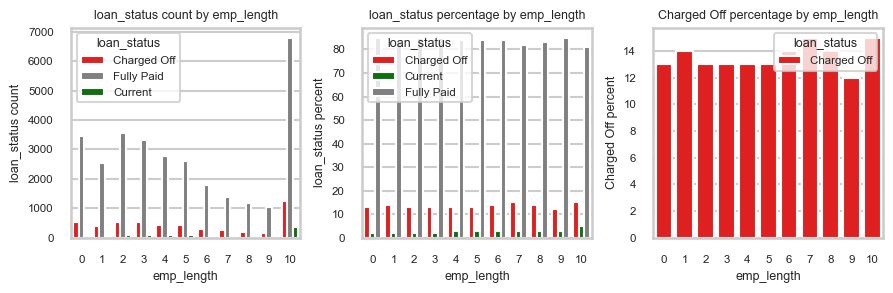

In [579]:
dcps(data=inp1, x='emp_length', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

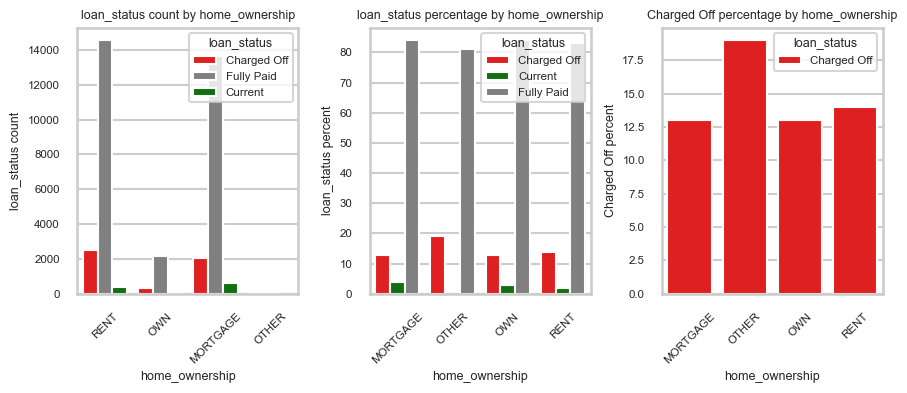

In [583]:
dcps(data=inp1, x='home_ownership', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=45, figsize=(9,4))

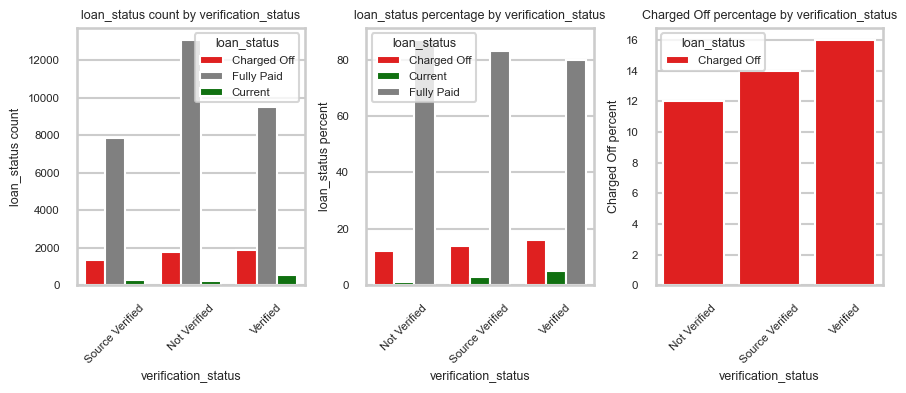

In [584]:
dcps(data=inp1, x='verification_status', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=45, figsize=(9,4))

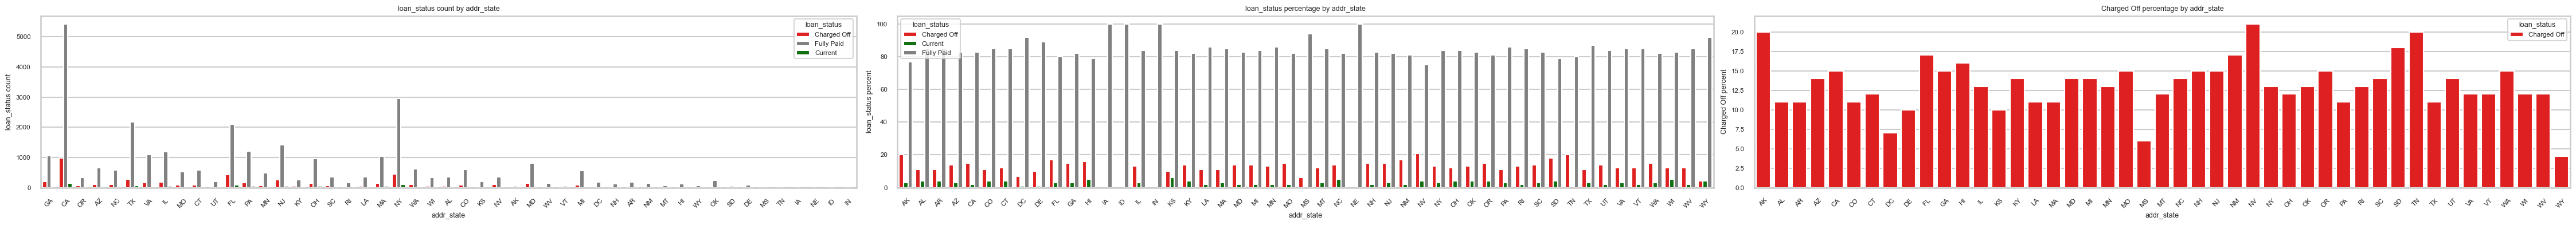

In [585]:
dcps(data=inp1, x='addr_state', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=45, figsize=(45,4))

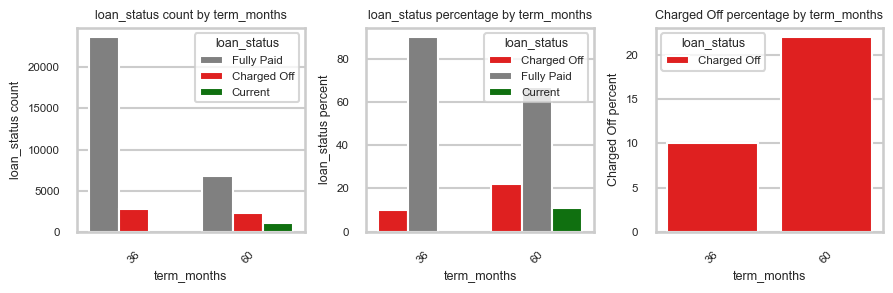

In [586]:
dcps(data=inp1, x='term_months', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=45)

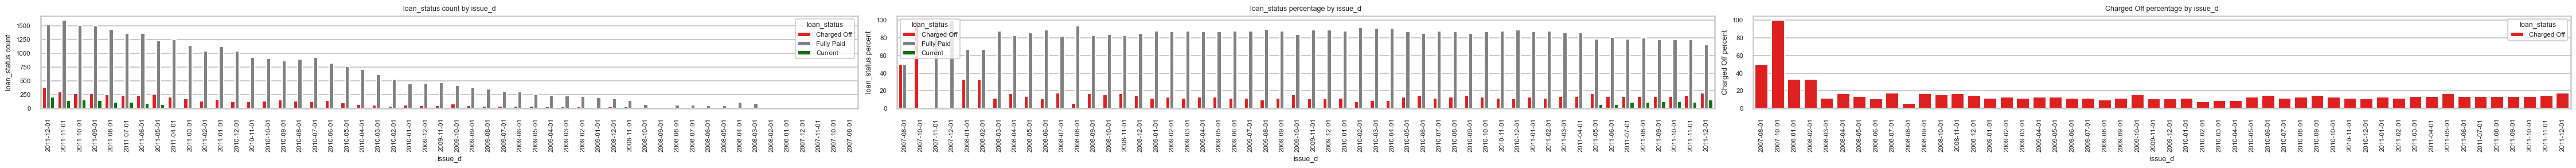

In [588]:
dcps(data=inp1, x='issue_d', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90, figsize=(45,3))

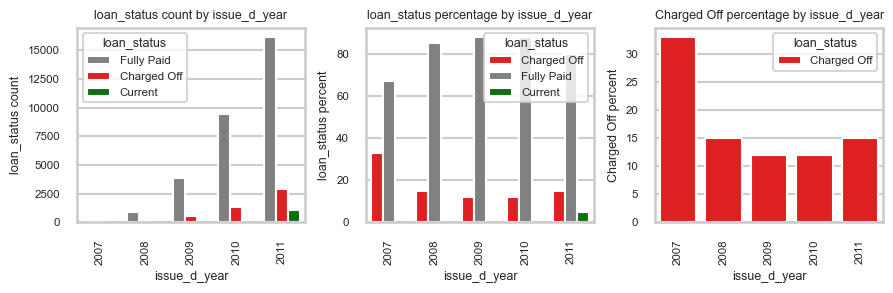

In [595]:
dcps(data=inp1, x='issue_d_year', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90)

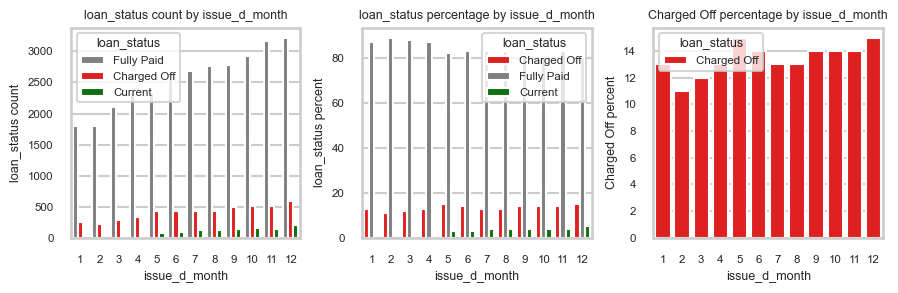

In [598]:
dcps(data=inp1, x='issue_d_month', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

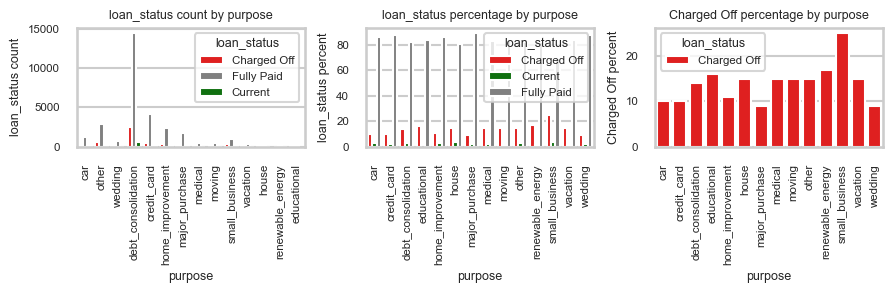

In [591]:
dcps(data=inp1, x='purpose', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90)

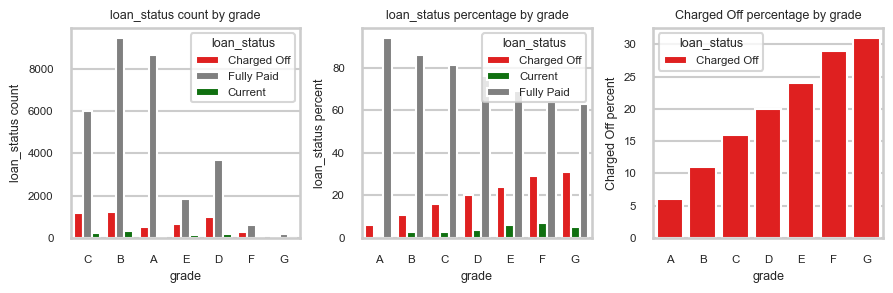

In [599]:
dcps(data=inp1, x='grade', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

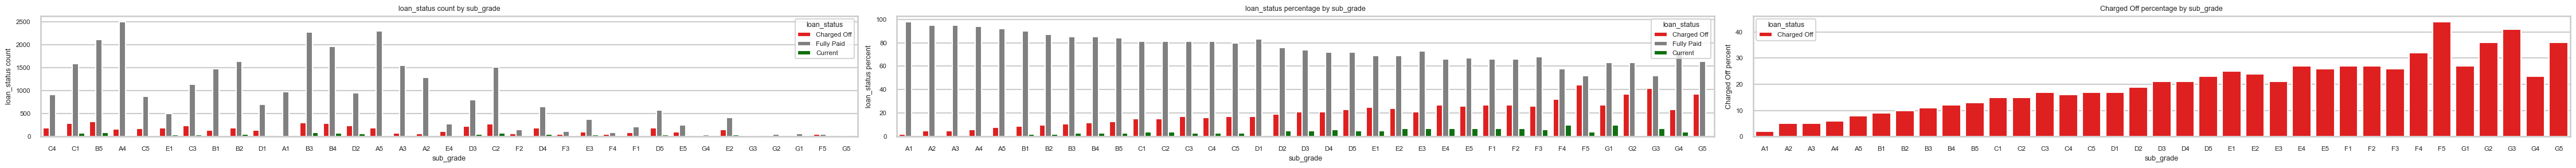

In [600]:
dcps(data=inp1, x='sub_grade', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', figsize=(45,3))

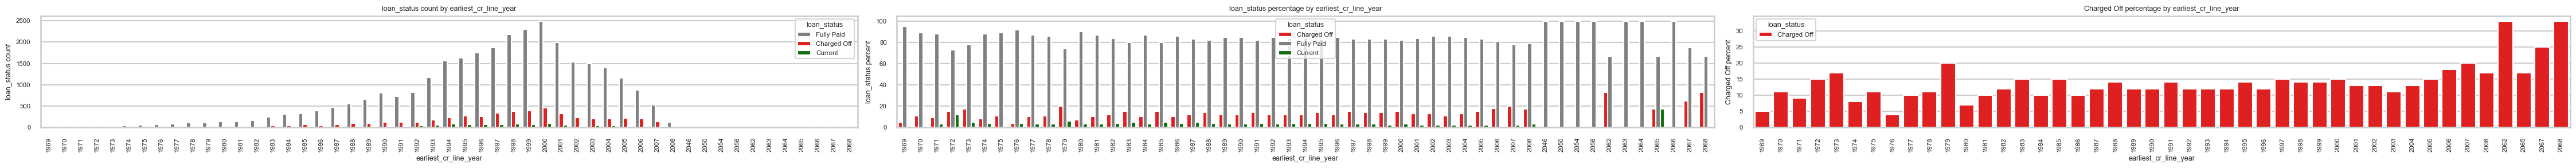

In [602]:
dcps(data=inp1, x='earliest_cr_line_year', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90, figsize=(45,3))

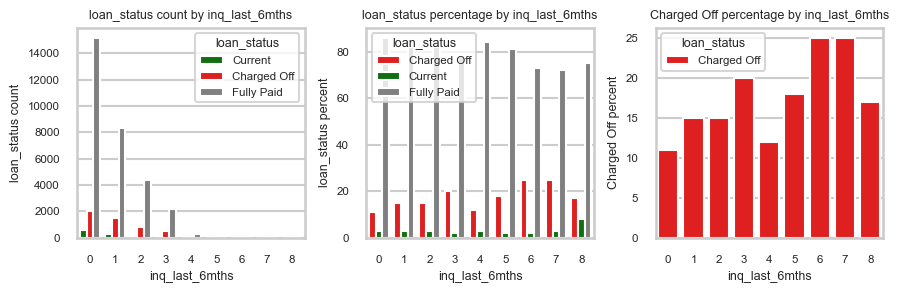

In [603]:
dcps(data=inp1, x='inq_last_6mths', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

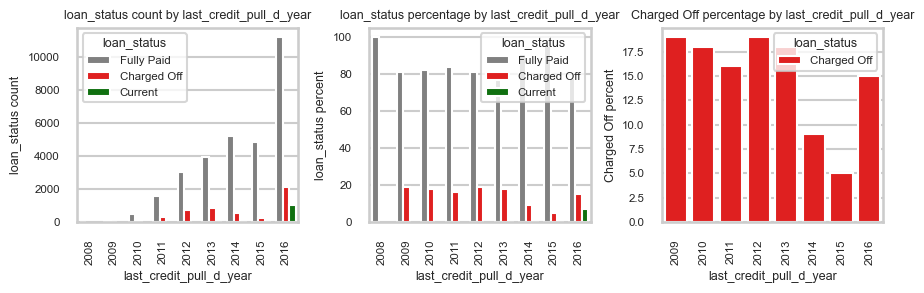

In [604]:
dcps(data=inp1, x='last_credit_pull_d_year', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90)

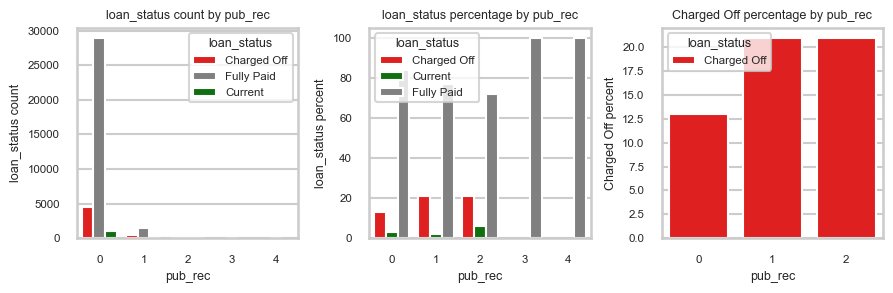

In [605]:
dcps(data=inp1, x='pub_rec', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

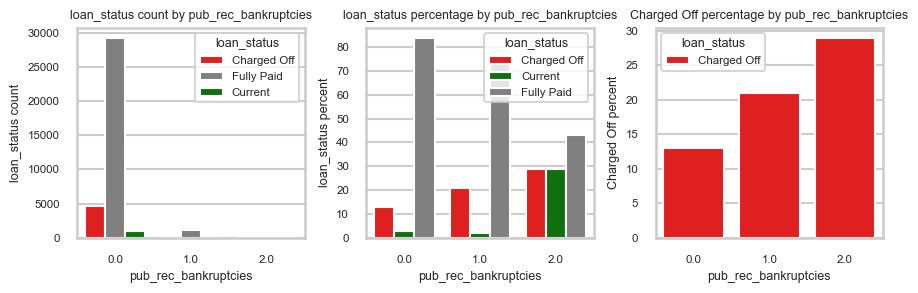

In [606]:
dcps(data=inp1, x='pub_rec_bankruptcies', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off')

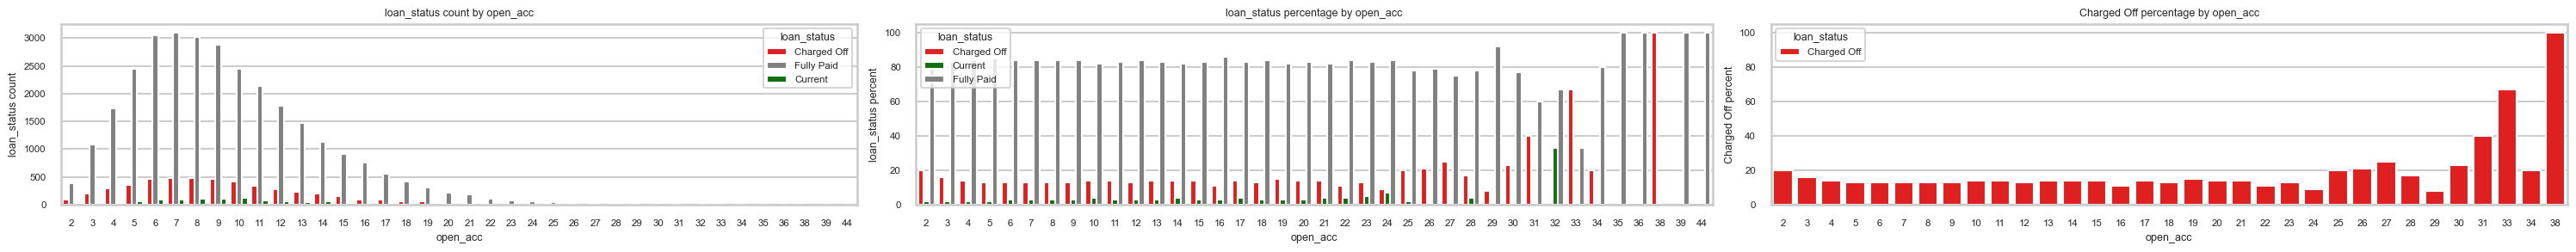

In [607]:
dcps(data=inp1, x='open_acc', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', figsize=(30,3))

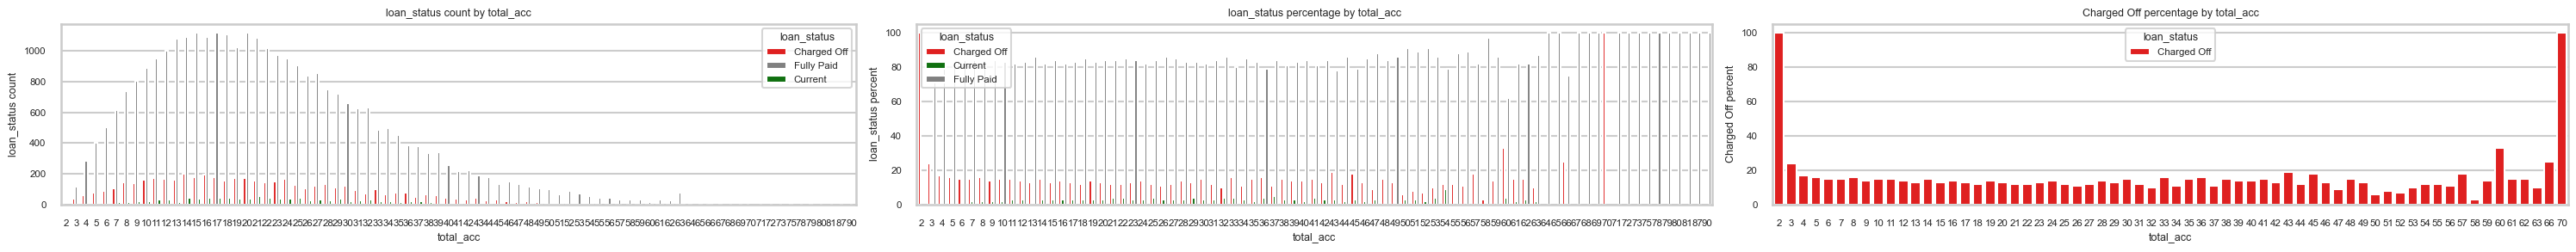

In [608]:
dcps(data=inp1, x='total_acc', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', figsize=(30,3))

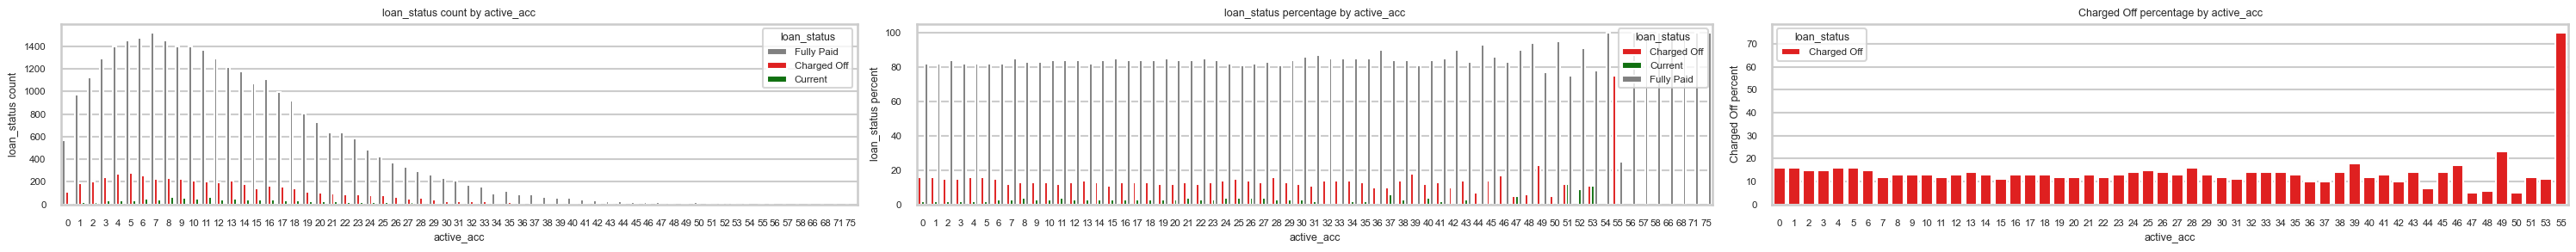

In [609]:
inp1['active_acc'] = inp1['total_acc'] - inp1['open_acc']
dcps(data=inp1, x='active_acc', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', figsize=(30,3))

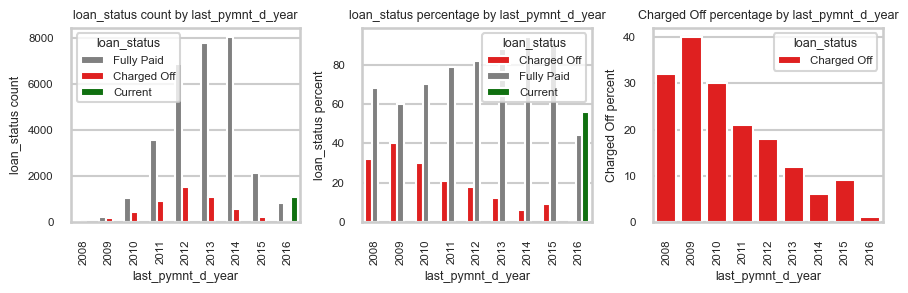

In [610]:
dcps(data=inp1, x='last_pymnt_d_year', hue='loan_status', palette=loan_status_palette, target_hue='Charged Off', xticks_rotation=90)